In [1]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import pandas
import tweetdf
import geopandas
import regions
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import numpy as np
import importlib
from shapely.geometry import Polygon

In [4]:
all_tweets = tweetdf.from_csv("../../dbs/Sweden.csv")

In [5]:
def filter_tweets_top_users(tws, top_users=100):
    topusers = tws.groupby('userid', as_index=False).count()[['userid', 'tweetid']].rename(columns={'tweetid': 'count'})
    topusers = topusers.sort_values(by='count', ascending=False).head(number_of_top_users)
    return topusers.merge(tws, on='userid')

In [6]:
tweets = all_tweets
tweets = geopandas.GeoDataFrame(
    tweets,
    crs="EPSG:4326",
    geometry=geopandas.points_from_xy(tweets.longitude, tweets.latitude),
)

In [7]:
tweets = tweets.drop(['timezone'], axis=1, ).dropna()

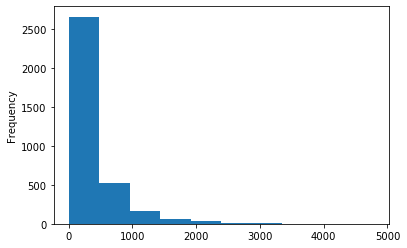

In [46]:
tweets.groupby("userid").size().plot(kind='hist')

# Homelocations

We estimate homelocation of each user with DBSCAN. The most visited location during evening and mornings on weekdays and all weekend is considered the homelocation.

In [9]:
def cluster_tweets(df, eps_km=0.1, min_samples=1):
    coords = df[['latitude', 'longitude']].values
    kms_per_radian = 6371.0088
    return DBSCAN(eps=eps_km/kms_per_radian, min_samples=min_samples, metric='haversine').fit(np.radians(coords))

In [10]:
def calculate_homelocation(df):
    """
    Input:
    Several rows from a GeoDataFrame for one user.
    columns = ['userid', 'weekday', 'hourofday', 'latitude', 'longitude', 'geometry']
    
    Output:
    One row from GeoDataFrame containing the estimated homelocation of the user.
    columns = ['userid', 'geometry']
    """
    weekdays = (df['weekday'] < 6) & (0 < df['weekday'])
    weekends = (df['weekday'] == 6) | (0 == df['weekday'])
    morning_evening = (df['hourofday'] < 10) | (17 < df['hourofday'])
    df2 = df[((weekdays) & (morning_evening)) | (weekends)].reset_index()
    cls = cluster_tweets(df2, eps_km=0.1, min_samples=1)
    labels = pandas.Series(cls.labels_)
    biggest_cluster_idx = labels.groupby(labels).size().argmax()
    return df2[labels == biggest_cluster_idx].head(1)[['userid', 'geometry']]

In [11]:
homelocations = tweets.groupby('userid', as_index=False).apply(calculate_homelocation)

In [12]:
homelocations

,,userid,geometry
0,40,5616,POINT (17.95618 59.40285)
1,5,8981,POINT (18.02686 59.31741)
2,51,392123,POINT (17.93338 59.29375)
3,11,578073,POINT (18.08528 59.29139)
4,1,618063,POINT (17.96375 59.36669)
...,...,...,...
3475,0,787921786927276032,POINT (12.75532 56.01999)
3476,0,790301765744951296,POINT (16.60000 59.91667)
3477,0,794973407964229636,POINT (18.07653 59.31426)
3478,6,797211605494824960,POINT (20.95000 64.76670)


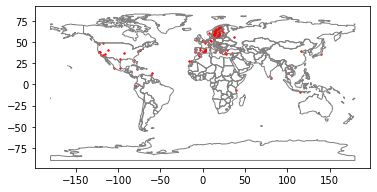

In [13]:
ax = homelocations.plot(color='red', markersize=2)
regions.countries_wgs.plot(ax=ax, facecolor='none', edgecolor='grey')

# Activities

We calculate activities for each user with DBSCAN. Each tweet is assigned a cluster, and the metrics `cluster_size` and `distance_km` (distance from estimated homelocation) are calculated.

In [15]:
def shapelypoint2latlng(p):
    return list([p.coords[0][0],p.coords[0][1]])

def activities_distance(activitiesdf, homelocationdf):
    userid = activitiesdf.iloc[0]['userid']
    # distance in kilometers
    distancefromhome = haversine_distances(
        X=np.radians(list(activitiesdf['geometry'].apply(shapelypoint2latlng).values)),
        Y=np.radians([shapelypoint2latlng(homelocationdf[homelocationdf['userid'] == userid].iloc[0]['geometry'])]),
    )*6371.0088
    return [_ for [_] in distancefromhome]

def calculate_activities(homels):
    """
    Function that can be "bound" to homelocations and then passed into DataFrame groupby.
    
    Input:
    `homels`
    GeoDataFrame of user's estimated homelocation.
    columns = ['userid', 'geometry']
    
    `tws`
    Several rows from a GeoDataFrame for one user.
    columns = ['userid', 'latitude', 'longitude', 'geometry', ...rest]
    
    Output:
    Several rows of GeoDataFrame corresponding to activities for this user.
    columns = ['userid', 'latitude', 'longitude', 'geometry', ...rest, 'cluster', 'distance_km', 'cluster_size']
    """
    def fn(tws):
        cls = cluster_tweets(tws, eps_km=0.1, min_samples=1)
        labels = pandas.Series(cls.labels_)
        # assign each tweet to a cluster
        tws2 = tws.assign(cluster=pandas.Series(cls.labels_, index=tws.index).values)
        # calculate the number of tweets in each cluster
        acts = tws2.groupby('cluster', as_index=False).apply(lambda df: geopandas.GeoDataFrame([
            [df.iloc[0]["cluster"], tws.iloc[0]["userid"], df.iloc[0]["geometry"], df.shape[0]],
        ], columns=['cluster', 'userid', 'geometry', 'cluster_size']))
        # calculate distance between clusters and user's homelocation
        acts = acts.assign(distance_km=activities_distance(acts, homels))
        acts = acts.drop(['geometry', 'userid'], axis=1)
        return tws2.merge(acts, on='cluster')
    return fn
    

In [16]:
activities = tweets.groupby('userid', as_index=False).apply(calculate_activities(homelocations))

In [17]:
activities = activities.reset_index(drop=True)

In [18]:
activities = activities.merge(
    activities.groupby('userid', as_index=False).count()[['userid','tweetid']].rename(columns={"tweetid": "tweet_count"}), 
    on='userid'
)

In [19]:
activities

,userid,tweetid,createdat,latitude,longitude,month,weekday,hourofday,geometry,cluster,cluster_size,distance_km,tweet_count
0,5616,306814580301119488,2013-02-27 18:14:30+01:00,57.599221,18.436371,2.0,3.0,18.0,POINT (18.43637 57.59922),0,10,197.864765,2171
1,5616,596331871241379840,2015-05-07 17:12:52+02:00,57.599221,18.436371,5.0,4.0,17.0,POINT (18.43637 57.59922),0,10,197.864765,2171
2,5616,623057810864111616,2015-07-20 11:12:12+02:00,57.599221,18.436371,7.0,1.0,11.0,POINT (18.43637 57.59922),0,10,197.864765,2171
3,5616,679673567416565760,2015-12-23 15:43:00+01:00,57.599221,18.436371,12.0,3.0,15.0,POINT (18.43637 57.59922),0,10,197.864765,2171
4,5616,757647103011262465,2016-07-25 20:42:00+02:00,57.599221,18.436371,7.0,1.0,20.0,POINT (18.43637 57.59922),0,10,197.864765,2171
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276010,806822309478727680,815619064613609472,2017-01-01 19:01:53+01:00,57.716700,12.916700,1.0,0.0,19.0,POINT (12.91670 57.71670),7,5,698.834252,44
1276011,806822309478727680,815835652486938624,2017-01-02 09:22:31+01:00,57.716700,12.916700,1.0,1.0,9.0,POINT (12.91670 57.71670),7,5,698.834252,44
1276012,806822309478727680,815937364736380928,2017-01-02 16:06:41+01:00,57.716700,12.916700,1.0,1.0,16.0,POINT (12.91670 57.71670),7,5,698.834252,44
1276013,806822309478727680,816003760006668288,2017-01-02 20:30:31+01:00,57.730060,12.942200,1.0,1.0,20.0,POINT (12.94220 57.73006),8,1,695.809625,44


## Distance from home

The below plot (note log-scale) indicates an overrepresentation of activities close to home. 

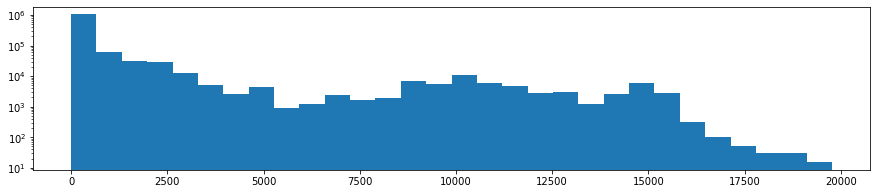

In [43]:
fig, ax = plt.subplots(1, figsize=(15,3))
_ = ax.hist(activities['distance_km'], bins=30, log=True)

## Classification

In line with paper (insert reference) we classify each activity into 5 categories. 
* Home
* Fixed close
* Fixed far
* Flexible close
* Flexible far

A fixed location is a location that have been visited often. Currently we define "often" as a location that have been visited more than a specific number of times. It would be interesting to see difference if percentage-based cutoff point is used. 

A close location is a location that lies within 5km from home.

In [29]:
home = activities['distance_km'] < 0.01
close = (activities['distance_km'] < 5)
fixed = (activities['cluster_size'] > 5)
s = pandas.Series(np.zeros(activities.shape[0], dtype=str))
s[close & fixed] = "fixed-close"
s[~close & fixed] = "fixed-far"
s[close & ~fixed] = "flex-close"
s[~close & ~fixed] = "flex-far"
s[home] = "home"
activities = activities.assign(category=s)

### Distribution

There is an even split between fixed and flexible locations.
However, there are more "far" locations than "close".

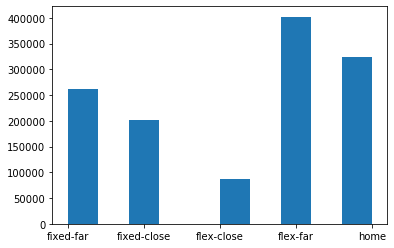

In [32]:
_ = plt.hist(activities['category'])

The distribution varies depending on the number of geotagged tweets a user have.
Fixed locations are more frequent the more tweets a user have. This is expected due to the absolute value cutoff for "fixed" vs "flexible" locations.
Number of geotagged tweets at home also increases as number of tweets increases.

In [68]:
activities = activities.assign(quantile=pandas.qcut(activities['tweet_count'], q=10))

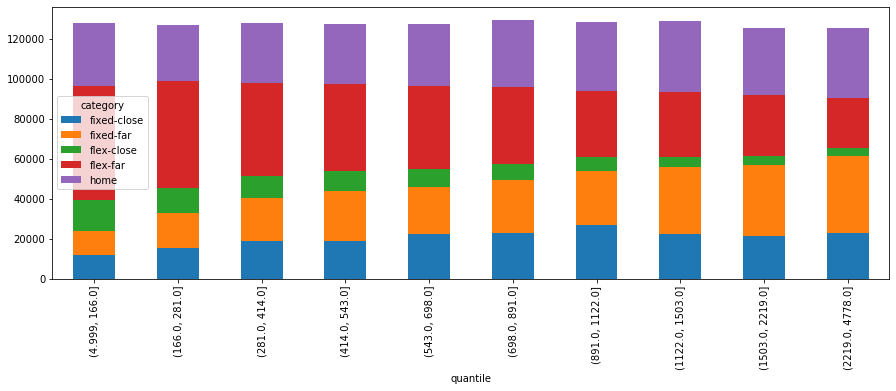

In [69]:
fig, ax = plt.subplots(figsize=(15, 5))
activities.groupby(['quantile', 'category']).size().unstack().fillna(0).plot(kind="bar", stacked=True, ax=ax)


In [91]:
def plot_category_distrib_quantiles(tws):
    grouped = tws.groupby('quantile')
    fig, axes = plt.subplots(nrows=grouped.ngroups, ncols=2, figsize=(15,50))
    idx = 0
    for key in grouped.groups.keys():
        ts = grouped.get_group(key)
        weekdays = ts[(ts['weekday'] < 6) & (0 < ts['weekday'])]
        weekends = ts[(ts['weekday'] == 6) | (0 == ts['weekday'])]
        axes[idx, 0].set_title("Weekdays - " + str(key))
        weekdays.groupby(['hourofday', 'category']).size().unstack().fillna(0).plot(ax=axes[idx, 0])
        axes[idx, 1].set_title("Weekends - " + str(key))
        weekends.groupby(['hourofday', 'category']).size().unstack().fillna(0).plot(ax=axes[idx, 1])
        idx += 1

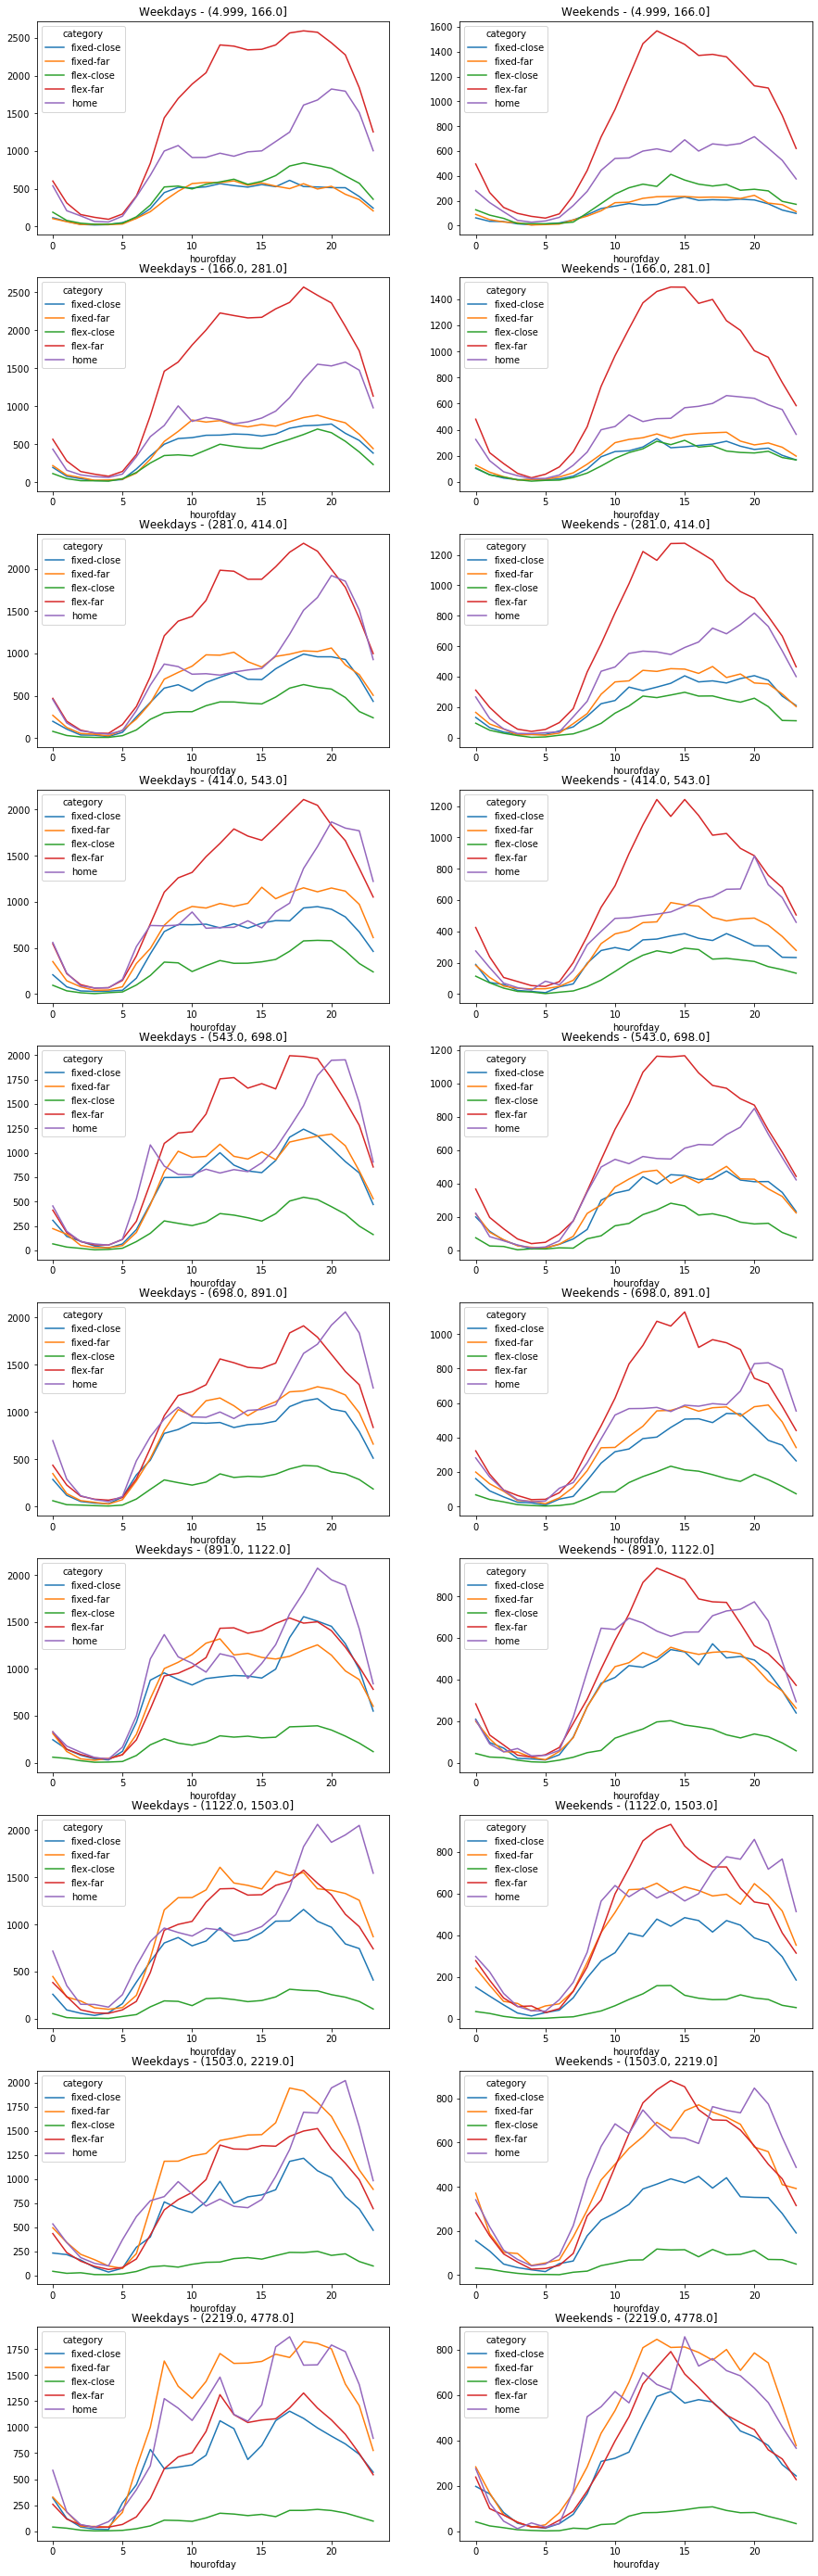

In [92]:
plot_category_distrib_quantiles(activities)